Copyright 2022 Google LLC.

SPDX-License-Identifier: Apache-2.0


# License

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at


# https://www.apache.org/licenses/LICENSE-2.0


# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Voxel-based Radiance Fields in JAX and FLAX

*Authors: Pedro Velez & Frank Dellaert*

## Introduction

Neural Radiance Fields (NeRF) exploded on the scene in 2020.

A big new trend is the emergence of voxel-based, very fast NeRF variants, all foregoing the large MLP at the center of the original NeRF paper. They are listed here in order of increasing complexity:

- [Plenoxels](https://alexyu.net/plenoxels) foregoes MLPs altogether and optimizes opacity and view-dependent color, using spherical harmonics (SH), directly on a 3D voxel grid. It stores 9 SH coefficients per vertex.

- [ReLu Fields](https://geometry.cs.ucl.ac.uk/group_website/projects/2022/relu_fields/) is a very similar paper, but uses an additional ReLU on top of the density. The color uses SH as in Plenoxels.

- [DVGO](https://sunset1995.github.io/dvgo/) is identical to Relu Fields for density, but replaces the color head with a small explicit-implixit hybrid MLP, feeding both position and view direction into the MLP, with positional encoding.

- [Instant NGP](https://nvlabs.github.io/instant-ngp/) is the most complex architecture, and uses multiple voxelgrids and hashing as a novel way to deal with sparse densities.

In this notebook we show how with jax/flax, it is relatively easy to quickly get a voxel-based NeRF variant up and running. Specifically, we will develop a simplified version of DVGO that directly regresses color instead of having a small MLP. It works remarkably well.

## Setup

First, we install some of the necessary libraries. Of course, we need `jax` and `flax`, but we also install mediapy for visualization purposes.

In [2]:
# Install the latest JAXlib version.
%pip install --upgrade -q pip jax jaxlib 
# Install Flax at head:
%pip install --upgrade -q git+https://github.com/google/flax.git
%pip install --upgrade -q git+https://github.com/google-research/sunds.git
%pip install -q mediapy

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Below we import all of these, and then some.

In [3]:
from typing import Callable, Tuple
Initializer = Callable

from functools import partial
import dataclasses
import time

import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds

import jax
import jax.numpy as jnp
from jax import random
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [5]:
import flax
import flax.linen as nn
from flax.core import freeze, unfreeze
from flax.core.frozen_dict import FrozenDict

import optax

In [6]:
import sunds
import mediapy as media
import tensorflow_datasets as tfds
# load synthetic nerf dataset locally
!mkdir ~/tensorflow_datasets/
!gsutil -q -m cp -r gs://kubric-public/tfds/nerf_synthetic_*/ ~/tensorflow_datasets/

mkdir: cannot create directory ‘/root/tensorflow_datasets/’: File exists


## Differentiable interpolation in 1D

We start simple, in 1D, by building a small differentiable 1D grid. The class `LineGrid` below is a minimal flax.linen module with variables, that are linearly interpolated at an input location. If the grid contains multi-dimensional feature vectors, the output has the same dimension: features are interpolated independently of one another.

The grid is always defined at points with coordinates 0.0 to float(size-1), e.g., LineGrid(size=5, features=3) will define 3D features at the locations 0.0, 1.0, 2.0, 3.0, and 4.0.

In [7]:
class LineGrid(nn.Module):
  size: int
  features: int = 1
  grid_init: Initializer = nn.initializers.lecun_normal()

  @staticmethod
  def interpolate(feature_grid, x):
    """Interpolate vectors on a regular grid at samples 0, 1, ... n-1."""
    xd, whole = jnp.modf(x) # 3.6 -> xd = 0.6
    x0 = whole.astype(int)  # x0 = 3
    x1 = x0 + 1             # z1 = 4

    def f(grid):
      return grid[x0] * (1.0 - xd) + grid[x1] * xd

    return jax.vmap(f, -1, -1)(feature_grid)

  @nn.compact
  def __call__(self, x):
    grid = self.param('grid', self.grid_init, (self.size + 1, self.features))
    return self.interpolate(grid, x)

## Training a LineGrid

Training in JAX is standard and easy: we set up a mean-squared error loss (MSE) and a train function that runs a specified number of epochs. Below we use standard stochastic gradient descent (SGD) from the `optax` library.

In [8]:
# Same as JAX version but using model.apply().
@jax.jit
def mse(variables, x_batched, y_batched):
  # Define the squared loss for a single pair (x,y)
  def squared_error(x, y):
    pred = model.apply(variables, x)
    return jnp.inner(y-pred, y-pred) / 2.0
  # Vectorize the previous to compute the average of the loss on all samples.
  return jnp.mean(jax.vmap(squared_error)(x_batched, y_batched))

def train(variables, x_samples, y_samples, learning_rate, num_epochs, checkpoint_freq=100):
  tx = optax.sgd(learning_rate=learning_rate)
  opt_state = tx.init(variables)
  loss_grad_fn = jax.value_and_grad(mse)

  for i in range(num_epochs):
    loss_val, grads = loss_grad_fn(variables, x_samples, y_samples)
    updates, opt_state = tx.update(grads, opt_state)
    variables = optax.apply_updates(variables, updates)
    if i % checkpoint_freq == 0:
      print('Loss step {}: '.format(i), loss_val)
  
  return variables

Below we first create a "ground truth" 1D grid, stored in `true_variables`, and then generate some training samples from it, directly using the `interpolate` method that we defined above. Because the LineGrid is fully differentiable, we can then regress the `trained_variables` from those samples, using a single call to `train`.

In [9]:
# Generate expected grid and ground truth
grid_size = 10
grid_values_scale = 2
true_grid = np.arange(grid_size+1).reshape((grid_size+1,1)) * grid_values_scale
true_variables = freeze({'params': {'grid': true_grid}})

# Generate training data
num_x = 128
key1, key2, key3, key4 = random.split(random.PRNGKey(42), num=4)
x_samples = random.uniform(key1, (num_x, 1)) 
x_samples += random.randint(key2, (num_x, 1), minval=0, maxval=grid_size)
y_samples = LineGrid.interpolate(true_grid, x_samples) + random.normal(key3, (num_x,1,1))

# Setup model and initialize parameters
model = LineGrid(size=grid_size)
variables = model.init(key4, x_samples)

trained_variables = train(variables, x_samples, y_samples, learning_rate=0.3, num_epochs=601)

Loss step 0:  63.487186
Loss step 100:  1.5596838
Loss step 200:  0.6766525
Loss step 300:  0.52439857
Loss step 400:  0.4857689
Loss step 500:  0.47576818
Loss step 600:  0.4731633


Below we show the result in red, along with the training samples in blue. This is the case where the grid stires scalar values, but we can just as well regress using vector-based values. This will come in handy when we later regress to RGB colors in the NeRF case.

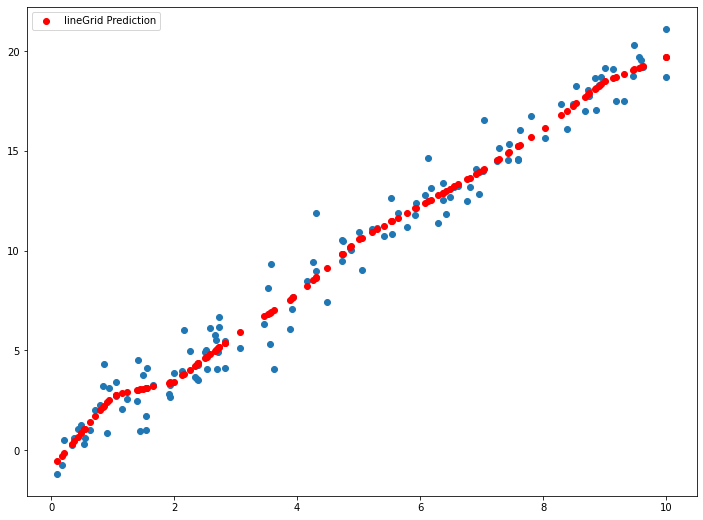

In [10]:
plt.figure(figsize=(12, 9))
plt.scatter(x_samples.flatten(), y_samples.flatten())
y_prediction = model.apply(trained_variables, x_samples)
plt.scatter(x_samples.flatten(), y_prediction.flatten(), c='red', label='lineGrid Prediction')
plt.legend()
plt.show()

## ImageGrid

`ImageGrid` is a grid of feature vectors arranged in a 2D grid. For a $w\times h=4\times 3$ image, we store those on the *corners* of the pixels, so we need storage of shape $(h+1,w+1, d)$, with $d$ the feature dimension. 

In [11]:
class ImageGrid(nn.Module):
  width: int
  height: int
  features: int = 1
  grid_init: Initializer = nn.initializers.lecun_normal()

  @staticmethod
  def interpolate(feature_grid, x, y):
    """Interpolate vectors on a regular 2D grid."""
    (xd, yd), whole = jnp.modf(jnp.stack([x, y]))
    x0, y0 = whole.astype(int)
    x1, y1 = x0 + 1, y0 + 1

    def f(grid):
      # Interpolate along x
      c0 = grid[y0, x0] * (1 - xd) + grid[y0, x1] * xd
      c1 = grid[y1, x0] * (1 - xd) + grid[y1, x1] * xd

      # Interpolate along y
      return c0 * (1 - yd) + c1 * yd

    return jax.vmap(f, -1, -1)(feature_grid)

  @nn.compact
  def __call__(self, p):
    grid = self.param('grid', self.grid_init,
                      (self.height + 1, self.width + 1, self.features))
    return self.interpolate(grid, p[..., 0], p[..., 1])

One application of the ImageGrid would be to train a "sky image", i.e., fit a panorama at a distance to store a direction-dependent background color.

## VoxelGrid

For a Voxel-based Radiance Field, we need a *3D* voxel volume. The `VoxelGrid` module below uses feature vectors arranged in a 3D grid. For a $w\times h \times d$ voxel grid, we store those on the *corners* of the voxels, so we need storage of shape $(d+1,h+1,w+1, d)$.

In [12]:
class VoxelGrid(nn.Module):
  width: int
  height: int
  depth: int
  features: int = 1
  grid_init: Initializer = nn.initializers.lecun_normal()

  @staticmethod
  def interpolate(feature_grid, x, y, z):
    """Interpolate vectors on a regular 3D grid."""
    (xd, yd, zd), whole = jnp.modf(jnp.stack([x, y, z]))
    x0, y0, z0 = whole.astype(int)
    x1, y1, z1 = x0 + 1, y0 + 1, z0 + 1

    def f(grid):
      # Interpolate along x
      c00 = grid[z0, y0, x0] * (1 - xd) + grid[z0, y0, x1] * xd
      c01 = grid[z0, y1, x0] * (1 - xd) + grid[z0, y1, x1] * xd
      c10 = grid[z1, y0, x0] * (1 - xd) + grid[z1, y0, x1] * xd
      c11 = grid[z1, y1, x0] * (1 - xd) + grid[z1, y1, x1] * xd

      # Interpolate along y
      c0 = c00 * (1 - yd) + c01 * yd
      c1 = c10 * (1 - yd) + c11 * yd

      # Interpolate along z
      return c0 * (1 - zd) + c1 * zd

    return jax.vmap(f, -1, -1)(feature_grid)

  @nn.compact
  def __call__(self, p):
    grid = self.param(
        'grid', self.grid_init,
        (self.depth + 1, self.height + 1, self.width + 1, self.features))
    return self.interpolate(grid, p[..., 0], p[..., 1], p[..., 2])

## Training a VoxelGrid

Directly supervising a 3D field of feature vectors is just as simple as in the 1D (or 2D) case. Because we redefine the `model` variable below as a `VoxelGrid` instance, we can reuse the `train` function as is!

In [13]:
# Generate expected grid and ground truth
W, H, D = 4, 3, 2
xx, yy, zz = np.meshgrid(np.arange(D+1), np.arange(H+1), np.arange(W+1), indexing='ij')
true_grid = xx + yy + zz
true_grid = jnp.expand_dims(true_grid, axis=3)
true_variables = freeze({'params': {'grid': true_grid}})

# Generate training data
num_x = 4096
x_samples = np.random.uniform(size=(num_x, 3))
for i, size in enumerate([W,H,D]):
  x_samples[:, i] += np.random.randint(0, size, size=(num_x))
y_samples = VoxelGrid.interpolate(true_grid, x_samples[:, 0], x_samples[:, 1], x_samples[:, 2])

# Setup model and initialize parameters
model = VoxelGrid(W, H, D)
variables = model.init(random.PRNGKey(42), x_samples)

trained_variables = train(variables, x_samples, y_samples, learning_rate=0.3, num_epochs=2500, checkpoint_freq=500)

Loss step 0:  11.062546
Loss step 500:  0.32209575
Loss step 1000:  0.075519726
Loss step 1500:  0.029905703
Loss step 2000:  0.015100392


## DVGO

For NeRF, we need to add volume rendering. We also need a bounding box scaling module to transform points from scene coordinates to grid coordinates:

In [14]:
@dataclasses.dataclass
class BBox(object):
  """Scaling coordinates to a bbox."""
  min_corner: Tuple[float, float, float] = (-1, -1, -1)
  max_corner: Tuple[float, float, float] = (1, 1, 1)

  def grid_from_scene(self, p):
    """Scale scene coordinates to axis-aligned bounding box."""
    min_corner = jnp.array(self.min_corner, float)
    max_corner = jnp.array(self.max_corner, float)
    scale = 1.0 / (max_corner - min_corner)
    unclamped = (p - min_corner) * scale
    return jnp.clip(unclamped, 0.0, 1.0)

We set up a Renderer class that we will inherit from as well: this provides the functionality to 
- sample 3D points along a ray (`sample_along_ray`)
- to take density and color values at those samples and perform volume rendering (`render`)

Note the Renderer also has a provision for a background color: if the total opacity along the ray *inside* the grid does not add up to 1, we use the remaining opacity to render the background color.

In [15]:
@dataclasses.dataclass
class Renderer(object):
  """Just the volume rendering code."""
  near: float = 0.0
  far: float = 1.0
  num_samples: int = 32
  background: Tuple[float, float, float] = (0., 0., 0.)

  def sample_along_ray(self, rng, ray_origin, ray_direction, randomized=False):
    """Sample along the ray."""
    t_vals = jnp.linspace(0., 1., self.num_samples + 1)
    t_vals = self.near * (1. - t_vals) + self.far * t_vals
    t_mids = 0.5 * (t_vals[1:] + t_vals[:-1])

    if randomized:
      upper = jnp.concatenate([t_mids, t_vals[-1:]], -1)
      lower = jnp.concatenate([t_vals[:1], t_mids], -1)
      t_rand = random.uniform(rng, [self.num_samples + 1])
      t_vals = lower + (upper - lower) * t_rand

    samples = ray_origin + jnp.expand_dims(t_mids, 1) * ray_direction
    return t_vals, samples

  def render(self, t_vals, ray_direction, density, rgb):
    """Volumetric Rendering Function."""
    t_dists = t_vals[1:] - t_vals[:-1]
    delta = t_dists * jnp.linalg.norm(ray_direction)
    density_delta = density * delta

    alpha = 1 - jnp.exp(-density_delta)
    trans = jnp.exp(-jnp.concatenate(
        [jnp.zeros_like(density_delta[:1]),
         jnp.cumsum(density_delta[:-1])]))
    weights = alpha * trans

    acc = weights.sum()
    return weights @ rgb + (1.0 - acc) * jnp.array(self.background)

Finally we provide the trainable density and color grids as two VoxelGrid instances. They just add a specific initializer function, and a non-linearity to make sure the output densitites and colors are scaled appropriately:

In [16]:
class DensityGrid(nn.Module):
  """Interpolate a 1D field and softplus it for density."""
  shape: Tuple[int, int, int]  # W, H, D

  @nn.compact
  def __call__(self, p):
    raw = VoxelGrid(
        *self.shape,
        features=1,
        grid_init=nn.initializers.constant(0.005),
        name='grid')(p)
    return nn.softplus(jnp.squeeze(raw))


class RGBGrid(nn.Module):
  """Interpolate a 3D (RGB) field and restrict to [0,1] with sigmoid."""
  shape: Tuple[int, int, int]  # W, H, D

  @nn.compact
  def __call__(self, p):
    raw = VoxelGrid(
        *self.shape,
        features=3,
        grid_init=nn.initializers.constant(0.0),
        name='grid')(p)
    return nn.sigmoid(raw)

Now we are ready to create the Simplified Differentiable Voxel Grid, or `SimpleDVGO`:

In [17]:
class SimpleDVGO(nn.Module, Renderer, BBox):
  """Simplified Differentiable Voxel Grid, see Sun et al. CVPR 2020."""
  shape: Tuple[int, int, int] = (128, 128, 128)  # W, H, D

  @nn.compact
  def __call__(self, rng, example, randomized=False):
    """Volume Rendering."""
    t_vals, samples = self.sample_along_ray(rng, example['ray_origins'],
                                            example['ray_directions'],
                                            randomized)
    rescaled = self.grid_from_scene(samples) * jnp.array([self.shape])
    density = DensityGrid(shape=self.shape, name='density')(rescaled)
    rgb = RGBGrid(shape=self.shape, name='color')(rescaled)
    return self.render(t_vals, example['ray_directions'], density, rgb)

## Examining the Scene
We will use the synthetic `lego` scene from the original NeRF paper. This dataset contains 100 `frame` instances, each with their own pose $T^s_i$ that converts from frame $i$ coordinates to scene coordinates.

Below we load the dataset using Google's [sunds](https://github.com/google-research/sunds) library. By specifying the `Scenes` task we get a description of the data rather than the data itself:



In [18]:
scene_ds = sunds.load('nerf_synthetic/lego', 
                      split='train',
                      task=sunds.tasks.Scenes())

There is only one element, which is a dictionary with scene information:

In [19]:
scene = scene_ds.get_single_element()
print(scene.keys())
print(f"scene_name = {scene['scene_name']}")
print(f"timestamp = {scene['timestamp']}")
print("scene_box:")
print(f"min_corner = {scene['scene_box']['min_corner'].numpy()}")
print(f"max_corner = {scene['scene_box']['max_corner'].numpy()}")

dict_keys(['frames', 'scene_box', 'scene_name', 'timestamp'])
scene_name = b'lego'
timestamp = 0.0
scene_box:
min_corner = [-0.637787 -1.140016 -0.344656]
max_corner = [0.633744 1.148737 1.002206]


In [20]:
bounding_box = tfds.as_numpy(scene['scene_box'])
for key, value in bounding_box.items():
  print(key, value)

max_corner [0.633744 1.148737 1.002206]
min_corner [-0.637787 -1.140016 -0.344656]


## Examining the Frames

The frames field contains a description for all frames. There are 100 frames, so let's examine the first 5 here:

In [21]:
frames = scene['frames']
print(f"Frame keys: {frames.keys()}")
print(f"Number of frames: {frames['frame_name'].shape}")
print(f"First 5 frame names: {frames['frame_name'].numpy()[:5]}")
print(f"First 5 time stamps: {frames['timestamp'].numpy()[:5]}")

Frame keys: dict_keys(['cameras', 'frame_name', 'pose', 'timestamp'])
Number of frames: (100,)
First 5 frame names: [b'lego_train_frame0000' b'lego_train_frame0001' b'lego_train_frame0002'
 b'lego_train_frame0003' b'lego_train_frame0004']
First 5 time stamps: [0. 0. 0. 0. 0.]


As you can see, in this synthetic dataset all time stamps are zero.

To show the images, we load just use the `Frames` task, which -as the name suggests- yields frames as tfds example objects. With yet anoteher cool Google library, [mediapy](https://github.com/google/mediapy), we can show some images:

In [22]:
frame_ds = sunds.load('nerf_synthetic/lego', 
                      split='train',
                      task=sunds.tasks.Frames())

The image size is $800 \times 800$. Below we show the first image at a quarter resolution:

Image shape:  (800, 800, 3)


lego_train_frame0007

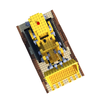

In [23]:
frame0 = next(iter(frame_ds))
image0 = frame0['cameras']['default_camera']['color_image']
print('Image shape: ', image0.shape)
media.show_image(image0, title=frame0['frame_name'].numpy().decode(), height=100)

But we can also show *all* 100 frames:

0007,0075,0040,0079,0091,0019,0028,0011,0057,0013,0027,0085,0082,0096,0071,0089,0045,0058,0035,0015
0041,0044,0090,0080,0020,0037,0026,0093,0039,0059,0049,0033,0003,0017,0074,0038,0005,0031,0088,0056
0052,0021,0077,0032,0053,0043,0054,0076,0061,0022,0098,0034,0067,0068,0050,0078,0046,0024,0000,0004
0062,0099,0094,0012,0087,0006,0073,0029,0083,0070,0009,0002,0081,0030,0018,0072,0008,0036,0025,0063
0042,0064,0086,0023,0016,0051,0084,0048,0066,0097,0055,0047,0060,0001,0065,0095,0069,0092,0014,0010

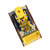
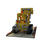
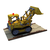
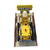
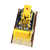
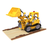
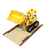
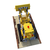
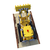
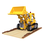
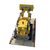
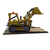
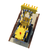
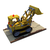
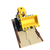
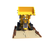
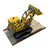
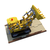
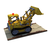
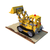
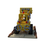
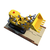
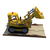
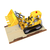
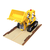
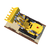
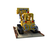
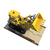
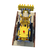
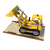
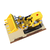
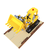
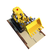
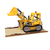
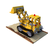
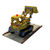
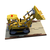
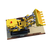
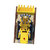
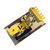
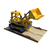
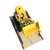
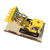
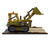
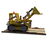
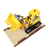
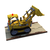
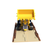
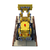
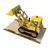
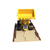
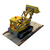
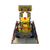
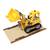
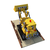
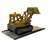
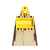
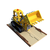
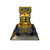
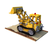
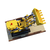
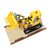
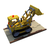
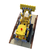
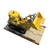
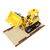
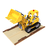
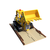
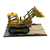
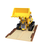
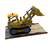
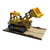
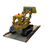
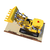
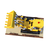
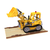
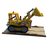
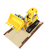
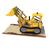
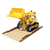
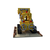
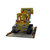
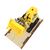
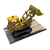
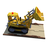
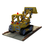
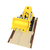
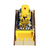
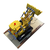
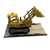
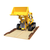
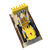
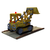
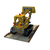
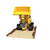
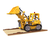
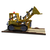
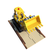
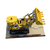
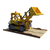

In [24]:
titles = [frame['frame_name'].numpy().decode()[-4:] for frame in frame_ds]
images = [frame['cameras']['default_camera']['color_image'].numpy() for frame in frame_ds]
media.show_images(images, height=50, titles=titles, columns=20)

## Volume Rendering

The real usefulness of [sunds](https://github.com/google-research/sunds) library for NeRF-style training is that it automatically calculates the rays for use! We do this using the `Nerf` task:

In [25]:
ds = sunds.load('nerf_synthetic/lego', split='train', 
                task=sunds.tasks.Nerf(yield_mode='image', ),
                shuffle_files=True).cache()
print(ds.element_spec)

{'color_image': TensorSpec(shape=(800, 800, 3), dtype=tf.uint8, name=None), 'ray_origins': TensorSpec(shape=(800, 800, 3), dtype=tf.float32, name=None), 'ray_directions': TensorSpec(shape=(800, 800, 3), dtype=tf.float32, name=None)}


We can use this to test the volume rendering functionality. First, we create some variables.

In [26]:
frame0 = tfds.as_numpy(next(iter(ds)))

In [27]:
scale = 32*3
W, H, D = scale * (bounding_box['max_corner']-bounding_box['min_corner']).astype(int) - 1
print(f"Grid W, H, D = {W, H, D}")

Grid W, H, D = (95, 191, 95)


In [28]:
dvgo = SimpleDVGO(shape=(W, H, D), near=2.5, far=5.5, num_samples=64, **bounding_box, background=(1, 1, 1))

In [29]:
color_grid = np.empty((D+1, H+1, W+1, 3))
color_grid[..., :] = np.array([0.0, 1.0, 0.0])
density_grid = np.full((D+1, H+1, W+1, 1), 0.0)
density_grid[:,H//2,:,:] = 1.0
variables = freeze({
    'params': {
        'color': {
            'grid': {
                'grid': color_grid
            }
        },
        'density': {
            'grid': {
                'grid': density_grid
            }
        }
    }
})

In [30]:
def downsample(frame, stride):
  return {k: v[::stride, ::stride] for k, v in frame.items()}

def select(frame, i):
  return {k: v[i] for k, v in frame.items()}

def render_image(variables, frame, stride=4):
  downsampled = downsample(frame, stride)
  # render one scanline at a time
  rng = random.PRNGKey(42)
  render_rays = jax.jit(jax.vmap(lambda ray: dvgo.apply(variables, rng=rng, example=ray, randomized=False)))
  rendered = np.stack([render_rays(select(downsampled, i))
                       for i in range(800//stride)])
  return rendered

In [31]:
stride = 8
rendered = render_image(variables, frame0, stride)

""

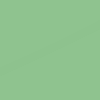

In [32]:
media.show_image(rendered)

## Batching Rays with `tfds`

In [33]:
num_images = 100
shuffled_images_ds = ds.shuffle(num_images)
batched_images_ds = shuffled_images_ds.batch(num_images, num_parallel_calls=tf.data.AUTOTUNE)

In [34]:
def sample_data(x, image_size):
  color_image = tf.reshape(x['color_image'], shape=[-1, 3])
  ray_origins = tf.reshape(x['ray_origins'], shape=[-1, 3])
  ray_directions = tf.reshape(x['ray_directions'], shape=[-1, 3])

  idx = tuple(np.random.choice(image_size, size=image_size, replace=False))

  return {
      'color_image': tf.gather(color_image, idx),
      'ray_origins': tf.gather(ray_origins, idx),
      'ray_directions': tf.gather(ray_directions, idx)}

In [35]:
# Note: this cell takes a long time approx: 3 mins
batch_size = 5000
image_resolution = 800*800
num_devices = jax.local_device_count()
mapped_images_ds = batched_images_ds.map(lambda x: sample_data(x, image_size=image_resolution*num_images), num_parallel_calls=tf.data.AUTOTUNE)
unbatched_mapped_ds = mapped_images_ds.unbatch()
batched_rays_ds = unbatched_mapped_ds.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)

In [36]:
first_ray = tfds.as_numpy(unbatched_mapped_ds.take(1).get_single_element())

## Train the Neural Radiance Field

In [37]:
@partial(jax.jit, static_argnames=['randomized'])
def mse(variables, ray_batch, rng, randomized=False):
  # Define the squared loss for a single ray
  def squared_error(ray, key):
    actual = ray['color_image'].astype(float)
    # TODO: clearly wrong to create keys here
    rendered = dvgo.apply(
        variables, rng=key, example=ray, randomized=randomized)
    error = 256*rendered - actual
    return jnp.abs(error)

  # Vectorize to compute the average MSE loss for all rays.
  num_rays = ray_batch['color_image'].shape[0]
  key_batch = random.split(rng, num_rays)
  return jnp.mean(jax.vmap(squared_error)(ray_batch, key_batch))

In [38]:
# Batched training
rng = random.PRNGKey(42)
key0, key1, rng = random.split(rng, 3)
# We currently have to give init *one* ray, not a batch
variables = dvgo.init(key0, rng=key1, example=first_ray)

In [39]:
tx = optax.adam(learning_rate=0.03)
opt_state = tx.init(variables)

num_epochs = 1
checkpoint_freq = 1000
max_iterations = 2000
loss_grad_fn = jax.value_and_grad(mse)

tic = time.time()
iter_count = 0
for i in range(num_epochs):
  for ray_batch in tqdm.tqdm(batched_rays_ds):
    key, rng = random.split(rng)
    loss_val, grads = loss_grad_fn(variables, 
                                   ray_batch=tfds.as_numpy(ray_batch), 
                                   rng=key, randomized=True)
    updates, opt_state = tx.update(grads, opt_state)
    variables = optax.apply_updates(variables, updates)
    if iter_count % checkpoint_freq == 0:
      print('Loss step {}: '.format(iter_count), loss_val)
    iter_count += 1
    if iter_count > max_iterations:  # Stopping at max_iterations on purpose to get an early trained model
      break
print(f'Completed training in {time.time() - tic} seconds.')

  0%|          | 10/12800 [00:30<7:45:48,  2.19s/it] 

Loss step 0:  98.14512


  8%|▊         | 1009/12800 [00:42<02:33, 76.82it/s]

Loss step 1000:  11.8499365


 16%|█▌        | 2000/12800 [00:55<04:59, 36.03it/s]

Loss step 2000:  9.551577
Completed training in 55.52354431152344 seconds.


## Examining the Result

Using the now trained `variables`, we can render the views and compare them side-by-side to the ground truth:

GT,rendered

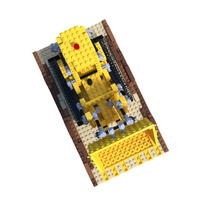
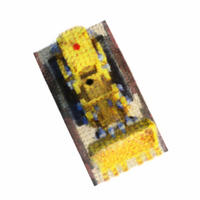

GT,rendered

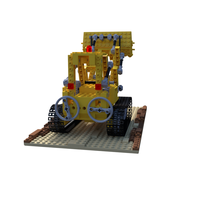
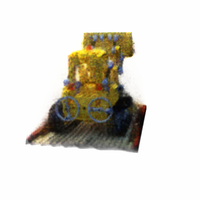

GT,rendered

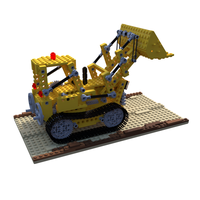
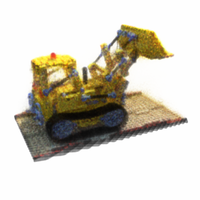

In [40]:
stride = 2
for frame in ds.take(3):
  image = frame['color_image']
  rendered = render_image(variables, tfds.as_numpy(frame), stride)
  media.show_images([image, rendered], 
                    titles=["GT", "rendered"], 
                    height=400//stride)